# Aurora Weather Forecasting with ECMWF Open Data

This notebook demonstrates near real-time global weather forecasting using Microsoft's Aurora AI model with ECMWF IFS Open Data as initial conditions.

## Overview

**Aurora** is a state-of-the-art foundation model for atmospheric forecasting developed by Microsoft Research. It uses a transformer-based architecture trained on decades of reanalysis data to provide high-resolution global weather predictions at 0.25° resolution.

**ECMWF Open Data** provides free access to operational IFS (Integrated Forecasting System) forecasts updated four times daily (00, 06, 12, 18 UTC). This data serves as perfect initial conditions for Aurora's neural weather model.

## Workflow Summary

1. **Environment Setup** - Configure dependencies and paths
2. **Data Discovery** - Detect latest available IFS forecast cycle
3. **Data Download** - Retrieve surface and atmospheric variables
4. **Data Preparation** - Format GRIB files for Aurora input
5. **AI Forecast** - Execute Aurora using ai-models framework
6. **Analysis** - Visualize and validate forecast output

## 1. Environment Setup

Import required libraries and configure the working environment. This implementation uses the ECMWF OpenData client for data access and the ai-models framework for Aurora execution.

In [1]:
import os
import sys
import subprocess
import time
import logging
from datetime import datetime, timedelta, timezone
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ecmwf.opendata import Client
import psutil
import torch

print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python version: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:48:41) [GCC 13.3.0]
Working directory: /scratch/qhuang62/ai-models-aurora
CUDA available: True
GPU device: NVIDIA A100-SXM4-80GB
GPU memory: 85.1 GB


## 2. Configuration

Define forecast parameters, create output directories, and configure logging. Aurora requires specific surface and atmospheric variables at multiple pressure levels.

In [2]:
LEAD_TIME = 72  # Forecast lead time in hours
OUTPUT_DIR = Path("demo_output")
LOG_LEVEL = logging.INFO

OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / "logs").mkdir(exist_ok=True)

logging.basicConfig(
    level=LOG_LEVEL,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(OUTPUT_DIR / "logs" / "aurora_demo.log")
    ]
)
logger = logging.getLogger(__name__)

sfc_file = OUTPUT_DIR / "ifs_surface.grib2"
pl_file = OUTPUT_DIR / "ifs_pressure_levels.grib2"
init_file = OUTPUT_DIR / "init.grib2"
aurora_output = OUTPUT_DIR / "aurora_forecast.grib"
netcdf_output = OUTPUT_DIR / "aurora_forecast.nc"

SURFACE_VARS = ["2t", "2d", "10u", "10v", "msl", "tp", "sp", "tcwv"]
PRESSURE_VARS = ["u", "v", "t", "q"]
PRESSURE_LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100]
IFS_CYCLES = [0, 6, 12, 18]

logger.info(f"Demo setup complete. Output directory: {OUTPUT_DIR}")
logger.info(f"Forecast parameters: {LEAD_TIME}h lead time")

print(f"Configuration complete")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Forecast lead time: {LEAD_TIME} hours")
print(f"Surface variables: {', '.join(SURFACE_VARS)}")
print(f"Pressure levels: {PRESSURE_LEVELS} hPa")

2025-08-20 16:22:00,123 - INFO - Demo setup complete. Output directory: demo_output
2025-08-20 16:22:00,196 - INFO - Forecast parameters: 72h lead time


Configuration complete
Output directory: demo_output
Forecast lead time: 72 hours
Surface variables: 2t, 2d, 10u, 10v, msl, tp, sp, tcwv
Pressure levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100] hPa


## 3. Latest IFS Cycle Detection

Automatically detect the most recent available IFS forecast cycle from ECMWF Open Data. The IFS model runs four times daily with approximately 3-4 hour processing delays.

In [3]:
import tempfile

def detect_latest_ifs_cycle():
    """
    Detect the latest available IFS cycle by testing actual data availability.
    
    Returns:
        tuple: (datetime object with UTC timezone, cycle_hour)
    """
    client = Client(source="ecmwf", model="ifs")
    now = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
    
    logger.info(f"Searching for latest IFS cycle. Current UTC time: {now.isoformat()}")
    
    for day_offset in [0, 1]:
        day = (now - timedelta(days=day_offset)).date()
        
        for hour in reversed(IFS_CYCLES):
            candidate_dt = datetime(day.year, day.month, day.day, hour, tzinfo=timezone.utc)
            
            if candidate_dt > now:
                continue
            
            date_str = candidate_dt.strftime("%Y-%m-%d")
            hour_str = f"{hour:02d}"
            
            with tempfile.NamedTemporaryFile(prefix="ecmwf_test_", suffix=".grib2", delete=False) as tmp:
                tmp_path = tmp.name
            
            try:
                client.retrieve(
                    date=date_str,
                    time=hour_str,
                    stream="oper",
                    type="fc",
                    step=0,
                    param="msl",
                    target=tmp_path,
                )
                
                if os.path.getsize(tmp_path) > 0:
                    logger.info(f"Found available cycle: {date_str} {hour_str}Z")
                    return candidate_dt, hour
                    
            except Exception as e:
                logger.debug(f"Cycle {date_str} {hour_str}Z not available: {str(e)[:100]}")
                
            finally:
                try:
                    os.remove(tmp_path)
                except Exception:
                    pass
    
    raise RuntimeError("No available IFS cycles found in the last 2 days")

print("Detecting latest available IFS cycle...")
start_time = time.time()

try:
    latest_date, latest_cycle = detect_latest_ifs_cycle()
    detection_time = time.time() - start_time
    
    print(f"Latest cycle detected in {detection_time:.1f}s")
    print(f"Date: {latest_date.strftime('%Y-%m-%d')}")
    print(f"Cycle: {latest_cycle:02d} UTC")
    print(f"Age: {(datetime.now(timezone.utc) - latest_date).total_seconds() / 3600:.1f} hours")
    
    client = Client(source="ecmwf", model="ifs")
    
except Exception as e:
    logger.error(f"Failed to detect latest cycle: {e}")
    raise

2025-08-20 16:22:00,202 - INFO - Searching for latest IFS cycle. Current UTC time: 2025-08-20T23:00:00+00:00


Detecting latest available IFS cycle...


2025-08-20 16:22:01,422 - INFO - Downloading https://data.ecmwf.int/forecasts/20250820/12z/ifs/0p25/oper/20250820120000-0h-oper-fc.grib2


20250820120000-0h-oper-fc.grib2:   0%|          | 0.00/512k [00:00<?, ?B/s]

2025-08-20 16:22:03,632 - INFO - Found available cycle: 2025-08-20 12Z


Latest cycle detected in 3.4s
Date: 2025-08-20
Cycle: 12 UTC
Age: 11.4 hours


In [4]:
def download_surface_data(client, date, cycle, output_file):
    """
    Download IFS surface variables for Aurora input.
    Downloads variables in separate groups to handle height level conflicts.
    """
    date_str = date.strftime("%Y-%m-%d")
    time_str = f"{cycle:02d}"
    
    logger.info(f"Downloading surface data: {date_str} {time_str}Z")
    logger.info(f"Variables: {', '.join(SURFACE_VARS)}")
    
    group1_vars = ["10u", "10v"]
    group2_vars = ["2t", "2d"]
    group3_vars = ["msl", "tp", "sp", "tcwv"]
    
    temp_files = []
    
    for i, var_group in enumerate([group1_vars, group2_vars, group3_vars], 1):
        if not var_group:
            continue
            
        temp_file = OUTPUT_DIR / f"surface_group_{i}.grib2"
        temp_files.append(temp_file)
        
        logger.info(f"Downloading surface group {i}: {var_group}")
        
        try:
            client.retrieve(
                date=date_str,
                time=time_str,
                stream="oper",
                type="fc",
                step="0",
                param=var_group,
                target=str(temp_file)
            )
        except Exception as e:
            logger.warning(f"Failed to download surface group {i} ({var_group}): {e}")
            if temp_file in temp_files:
                temp_files.remove(temp_file)
    
    if temp_files:
        logger.info(f"Concatenating {len(temp_files)} surface files")
        with open(output_file, "wb") as outfile:
            for temp_file in temp_files:
                if temp_file.exists():
                    with open(temp_file, "rb") as infile:
                        outfile.write(infile.read())
                    temp_file.unlink()
    else:
        raise RuntimeError("No surface data downloaded successfully")
    
    file_size = output_file.stat().st_size / (1024 * 1024)
    logger.info(f"Surface data downloaded: {file_size:.1f} MB")

print("Downloading surface variables...")
print(f"Variables: {', '.join(SURFACE_VARS)}")

start_time = time.time()

try:
    download_surface_data(client, latest_date, latest_cycle, sfc_file)
    download_time = time.time() - start_time
    file_size = sfc_file.stat().st_size / (1024 * 1024)
    
    print(f"Surface data downloaded in {download_time:.1f}s")
    print(f"File size: {file_size:.1f} MB")
    print(f"Saved to: {sfc_file}")
    
except Exception as e:
    logger.error(f"Failed to download surface data: {e}")
    raise

print("\nValidating surface data...")
try:
    ds_sfc = xr.open_dataset(
        sfc_file, 
        engine="cfgrib",
        backend_kwargs={"errors": "ignore"}
    )
    print(f"Surface data validation successful")
    print(f"Variables found: {list(ds_sfc.data_vars.keys())}")
    print(f"Grid shape: {dict(ds_sfc.sizes)}")
    ds_sfc.close()
except Exception as e:
    logger.warning(f"Surface data validation failed: {e}")
    print(f"Could not validate surface data (file may still be valid)")

2025-08-20 16:22:03,640 - INFO - Downloading surface data: 2025-08-20 12Z
2025-08-20 16:22:03,640 - INFO - Variables: 2t, 2d, 10u, 10v, msl, tp, sp, tcwv
2025-08-20 16:22:03,641 - INFO - Downloading surface group 1: ['10u', '10v']


Variables: 2t, 2d, 10u, 10v, msl, tp, sp, tcwv


2025-08-20 16:22:04,441 - INFO - Downloading https://data.ecmwf.int/forecasts/20250820/12z/ifs/0p25/oper/20250820120000-0h-oper-fc.grib2


20250820120000-0h-oper-fc.grib2:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

2025-08-20 16:22:05,724 - INFO - Downloading surface group 2: ['2t', '2d']
2025-08-20 16:22:06,531 - INFO - Downloading https://data.ecmwf.int/forecasts/20250820/12z/ifs/0p25/oper/20250820120000-0h-oper-fc.grib2


20250820120000-0h-oper-fc.grib2:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

2025-08-20 16:22:07,542 - INFO - Downloading surface group 3: ['msl', 'tp', 'sp', 'tcwv']
2025-08-20 16:22:08,370 - INFO - Downloading https://data.ecmwf.int/forecasts/20250820/12z/ifs/0p25/oper/20250820120000-0h-oper-fc.grib2


20250820120000-0h-oper-fc.grib2:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

2025-08-20 16:22:09,764 - INFO - Concatenating 3 surface files
2025-08-20 16:22:09,917 - INFO - Surface data downloaded: 4.4 MB


Surface data downloaded in 6.3s
File size: 4.4 MB
Saved to: demo_output/ifs_surface.grib2

Validating surface data...
Surface data validation successful
Variables found: ['u10', 'v10', 'tcwv', 'tp', 'msl', 'sp']
Grid shape: {'latitude': 721, 'longitude': 1440}


## 4. Download Pressure Level Data

Download atmospheric variables on multiple pressure levels. These provide the three-dimensional atmospheric state required by Aurora for accurate forecasting.

In [5]:
def download_pressure_level_data(client, date, cycle, output_file):
    """
    Download IFS pressure level variables for Aurora input.
    """
    date_str = date.strftime("%Y-%m-%d")
    time_str = f"{cycle:02d}"
    
    logger.info(f"Downloading pressure level data: {date_str} {time_str}Z")
    logger.info(f"Variables: {', '.join(PRESSURE_VARS)}")
    logger.info(f"Levels: {PRESSURE_LEVELS} hPa")
    
    client.retrieve(
        date=date_str,
        time=time_str,
        stream="oper",
        type="fc",
        step="0",
        param=PRESSURE_VARS,
        levelist=PRESSURE_LEVELS,
        target=str(output_file)
    )
    
    file_size = output_file.stat().st_size / (1024 * 1024)
    logger.info(f"Pressure level data downloaded: {file_size:.1f} MB")

print("Downloading pressure level variables...")
print(f"Variables: {', '.join(PRESSURE_VARS)}")
print(f"Levels: {PRESSURE_LEVELS} hPa")

start_time = time.time()

try:
    download_pressure_level_data(client, latest_date, latest_cycle, pl_file)
    download_time = time.time() - start_time
    file_size = pl_file.stat().st_size / (1024 * 1024)
    
    print(f"Pressure level data downloaded in {download_time:.1f}s")
    print(f"File size: {file_size:.1f} MB")
    print(f"Saved to: {pl_file}")
    
except Exception as e:
    logger.error(f"Failed to download pressure level data: {e}")
    raise

print("\nValidating pressure level data...")
try:
    ds_pl = xr.open_dataset(pl_file, engine="cfgrib")
    print(f"Pressure level data validation successful")
    print(f"Variables found: {list(ds_pl.data_vars.keys())}")
    print(f"Grid shape: {ds_pl.dims}")
    if 'isobaricInhPa' in ds_pl.dims:
        print(f"Pressure levels: {ds_pl.isobaricInhPa.values} hPa")
    ds_pl.close()
except Exception as e:
    logger.warning(f"Pressure level data validation failed: {e}")
    print(f"Could not validate pressure level data (file may still be valid)")

2025-08-20 16:22:13,869 - INFO - Downloading pressure level data: 2025-08-20 12Z
2025-08-20 16:22:13,870 - INFO - Variables: u, v, t, q
2025-08-20 16:22:13,870 - INFO - Levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100] hPa


Variables: u, v, t, q
Levels: [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100] hPa


2025-08-20 16:22:14,727 - INFO - Downloading https://data.ecmwf.int/forecasts/20250820/12z/ifs/0p25/oper/20250820120000-0h-oper-fc.grib2


20250820120000-0h-oper-fc.grib2:   0%|          | 0.00/30.5M [00:00<?, ?B/s]

2025-08-20 16:22:26,573 - INFO - Pressure level data downloaded: 30.5 MB


Pressure level data downloaded in 12.7s
File size: 30.5 MB
Saved to: demo_output/ifs_pressure_levels.grib2

Validating pressure level data...
Pressure level data validation successful
Variables found: ['q', 't', 'u', 'v']
Grid shape: FrozenMappingWarningOnValuesAccess({'isobaricInhPa': 12, 'latitude': 721, 'longitude': 1440})
Pressure levels: [1000.  925.  850.  700.  600.  500.  400.  300.  250.  200.  150.  100.] hPa


## 5. Data Preparation

Combine surface and pressure level GRIB files into a single initialization file for Aurora. This concatenation preserves all meteorological fields in the format expected by the AI model.

In [6]:
def create_aurora_input(surface_file, pressure_file, output_file):
    """
    Concatenate surface and pressure level GRIB files for Aurora input.
    """
    logger.info("Creating Aurora input file by concatenating GRIB files")
    
    cmd = ["cat", str(surface_file), str(pressure_file)]
    
    with open(output_file, "wb") as outfile:
        result = subprocess.run(cmd, stdout=outfile, stderr=subprocess.PIPE)
    
    if result.returncode != 0:
        error_msg = result.stderr.decode()
        raise RuntimeError(f"GRIB concatenation failed: {error_msg}")
    
    file_size = output_file.stat().st_size / (1024 * 1024)
    logger.info(f"Aurora input file created: {file_size:.1f} MB")

print("Creating Aurora input file...")
print(f"Combining: {sfc_file.name} + {pl_file.name}")

start_time = time.time()

try:
    create_aurora_input(sfc_file, pl_file, init_file)
    concat_time = time.time() - start_time
    file_size = init_file.stat().st_size / (1024 * 1024)
    
    print(f"Aurora input created in {concat_time:.1f}s")
    print(f"Combined file size: {file_size:.1f} MB")
    print(f"Saved to: {init_file}")
    
    sfc_size = sfc_file.stat().st_size / (1024 * 1024)
    pl_size = pl_file.stat().st_size / (1024 * 1024)
    expected_size = sfc_size + pl_size
    
    print(f"\nSize verification:")
    print(f"   Surface: {sfc_size:.1f} MB")
    print(f"   Pressure: {pl_size:.1f} MB")
    print(f"   Combined: {file_size:.1f} MB (expected: {expected_size:.1f} MB)")
    
    if abs(file_size - expected_size) < 0.1:
        print(f"File size verification passed")
    else:
        print(f"File size mismatch - check concatenation")
        
except Exception as e:
    logger.error(f"Failed to create Aurora input: {e}")
    raise

2025-08-20 16:22:26,741 - INFO - Creating Aurora input file by concatenating GRIB files


Creating Aurora input file...
Combining: ifs_surface.grib2 + ifs_pressure_levels.grib2


2025-08-20 16:22:27,305 - INFO - Aurora input file created: 34.9 MB


Aurora input created in 0.6s
Combined file size: 34.9 MB
Saved to: demo_output/init.grib2

Size verification:
   Surface: 4.4 MB
   Pressure: 30.5 MB
   Combined: 34.9 MB (expected: 34.9 MB)
File size verification passed


## 6. Aurora Forecast Execution

Execute the Aurora AI weather model using the ai-models CLI framework. This approach follows ECMWF's recommended implementation, allowing Aurora to handle data download and formatting automatically while leveraging GPU acceleration for neural network inference.

In [7]:
print("Checking Aurora dependencies...")

try:
    import ai_models
    print("✓ ai-models package available")
except ImportError:
    print("✗ ai-models not found - install with: pip install ai-models")

try:
    result = subprocess.run(["ai-models", "aurora", "--help"], 
                          capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("✓ Aurora model available via ai-models CLI")
    else:
        print("✗ Aurora model not available")
        print("Install with: pip install ai-models-aurora")
except Exception as e:
    print(f"✗ Cannot test Aurora CLI: {e}")
    print("Install dependencies with: pip install ai-models ai-models-aurora")

print("\nIf Aurora is not available, run:")
print("!pip install ai-models ai-models-aurora")

Checking Aurora dependencies...
✓ ai-models package available
✓ Aurora model available via ai-models CLI

If Aurora is not available, run:
!pip install ai-models ai-models-aurora


## 6. Aurora AI Forecast

Run Aurora using the ai-models framework with ECMWF Open Data integration. This leverages GPU acceleration and may take 10-30 minutes depending on forecast lead time and hardware capabilities.

In [8]:
def run_aurora_forecast(output_dir, lead_time_hours=72, date=None, cycle=None):
    """
    Execute Aurora forecast using ai-models CLI with ECMWF Open Data integration.
    """
    out_dir = Path(output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if date is not None and cycle is not None:
        if isinstance(date, str) and "-" in date:
            date_int = int(date.replace("-", ""))
        else:
            date_int = int(date)
        out_file = out_dir / f"aurora_{date_int}_{int(cycle):02d}z_{lead_time_hours}h.grib"
    else:
        out_file = out_dir / f"aurora_latest_{lead_time_hours}h.grib"

    if out_file.exists() and out_file.is_dir():
        raise RuntimeError(f"Path for --path is a directory: {out_file}")

    if out_file.exists():
        out_file.unlink()

    cmd = [
        "ai-models", "aurora",
        "--input", "ecmwf-open-data",
        "--lead-time", str(lead_time_hours),
        "--output", "file",
        "--path", str(out_file)
    ]

    if date is not None and cycle is not None:
        if isinstance(date, str) and "-" in date:
            date_int = int(date.replace("-", ""))
        else:
            date_int = int(date)
        cmd += ["--date", str(date_int), "--time", str(int(cycle))]

    logger.info(f"Command: {' '.join(cmd)}")
    res = subprocess.run(cmd, capture_output=True, text=True)

    logger.info(f"Aurora returncode={res.returncode}")
    if res.stdout: 
        logger.info(f"Aurora stdout:\n{res.stdout}")
    if res.stderr: 
        logger.warning(f"Aurora stderr:\n{res.stderr}")

    if res.returncode != 0:
        raise RuntimeError("Aurora failed (non-zero exit). See stderr above.")

    if not out_file.exists() or out_file.stat().st_size == 0:
        raise RuntimeError(f"Aurora reported success but wrote no GRIB to {out_file}")

    return res.stdout, res.stderr, out_file

print("Running Aurora forecast using ECMWF Open Data integration...")
print(f"Lead time: {LEAD_TIME} hours")
print(f"Method: ai-models aurora --input ecmwf-open-data")
print(f"This step uses GPU acceleration and may take 10-30 minutes")

gpu_memory_before = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
cpu_percent_before = psutil.cpu_percent()
memory_before = psutil.virtual_memory().percent

print(f"\nSystem status before Aurora:")
print(f"   CPU: {cpu_percent_before:.1f}%")
print(f"   Memory: {memory_before:.1f}%")
if torch.cuda.is_available():
    print(f"   GPU memory: {gpu_memory_before:.1f} GB")

start_time = time.time()

try:
    if 'latest_date' in locals() and 'latest_cycle' in locals():
        date_int = int(latest_date.strftime("%Y%m%d"))
        print(f"Using detected cycle: {date_int} {latest_cycle:02d}Z")
        
        stdout, stderr, actual_output_file = run_aurora_forecast(
            OUTPUT_DIR, LEAD_TIME, date_int, latest_cycle
        )
    else:
        print("Using latest available data automatically")
        stdout, stderr, actual_output_file = run_aurora_forecast(
            OUTPUT_DIR, LEAD_TIME
        )
    
    if actual_output_file != aurora_output:
        actual_output_file.rename(aurora_output)
        logger.info(f"Renamed output file to: {aurora_output}")
    
    forecast_time = time.time() - start_time
    file_size = aurora_output.stat().st_size / (1024 * 1024)
    
    print(f"Aurora forecast completed in {forecast_time:.1f}s ({forecast_time/60:.1f} min)")
    print(f"Output file size: {file_size:.1f} MB")
    print(f"Saved to: {aurora_output}")
    
    if torch.cuda.is_available():
        gpu_memory_after = torch.cuda.memory_allocated() / 1e9
        print(f"GPU memory after: {gpu_memory_after:.1f} GB")
    
    cpu_percent_after = psutil.cpu_percent()
    memory_after = psutil.virtual_memory().percent
    
    print(f"\nSystem status after Aurora:")
    print(f"   CPU: {cpu_percent_after:.1f}%")
    print(f"   Memory: {memory_after:.1f}%")
    
    if stdout and stdout.strip():
        print(f"\nAurora output:")
        print(stdout)
        
    print("\nSUCCESS: Aurora forecast completed!")
        
except Exception as e:
    logger.error(f"Aurora forecast failed: {e}")
    print(f"Aurora forecast failed: {e}")
    
    print(f"\nTrying fallback: Aurora with automatic latest data selection")
    try:
        stdout, stderr, actual_output_file = run_aurora_forecast(OUTPUT_DIR, LEAD_TIME)
        
        if actual_output_file != aurora_output:
            actual_output_file.rename(aurora_output)
        
        forecast_time = time.time() - start_time
        file_size = aurora_output.stat().st_size / (1024 * 1024)
        
        print(f"Aurora forecast completed in {forecast_time:.1f}s ({forecast_time/60:.1f} min)")
        print(f"Output file size: {file_size:.1f} MB")
        print(f"SUCCESS: Aurora forecast completed with automatic data selection!")
        
    except Exception as e2:
        print(f"Fallback also failed: {e2}")
        raise e

2025-08-20 16:22:28,440 - INFO - Command: ai-models aurora --input ecmwf-open-data --lead-time 72 --output file --path demo_output/aurora_20250820_12z_72h.grib --date 20250820 --time 12


Running Aurora forecast using ECMWF Open Data integration...
Lead time: 72 hours
Method: ai-models aurora --input ecmwf-open-data
This step uses GPU acceleration and may take 10-30 minutes

System status before Aurora:
   CPU: 6.9%
   Memory: 7.7%
   GPU memory: 0.0 GB
Using detected cycle: 20250820 12Z


2025-08-20 16:28:44,246 - INFO - Aurora returncode=0
2025-08-20 16:28:44,329 - INFO - Aurora stdout:
Interpolated data /tmp/tmprg65pcpk.tmp
Interpolated data /tmp/tmpvizn0tia.tmp
Interpolated data /tmp/tmpd64y45o_.tmp
Interpolated data /tmp/tmp76y_w2eh.tmp

2025-08-20 16:28:44,336 - WARNING - Aurora stderr:
2025-08-20 16:22:38,855 INFO Writing results to demo_output/aurora_20250820_12z_72h.grib
2025-08-20 16:22:38,855 INFO Model is Aurora0p1FineTuned, use_lora=True
2025-08-20 16:22:51,254 INFO Using device 'CUDA'. The speed of inference depends greatly on the device.
2025-08-20 16:22:52,409 INFO Downloading Aurora model aurora-0.1-finetuned.ckpt
2025-08-20 16:23:17,791 INFO Loading Aurora model to device cuda
2025-08-20 16:23:17,798 INFO Loading pressure fields from OPENDATA
2025-08-20 16:23:17,798 INFO Interpolating input data from (0.25, 0.25) to (0.1, 0.1).
2025-08-20 16:23:17,798 WARNING This will oversample the input data.
2025-08-20 16:23:17,798 WARNING Parameter 'z' on pressure 

Aurora forecast completed in 376.8s (6.3 min)
Output file size: 2938.6 MB
Saved to: demo_output/aurora_forecast.grib
GPU memory after: 0.0 GB

System status after Aurora:
   CPU: 8.8%
   Memory: 7.7%

Aurora output:
Interpolated data /tmp/tmprg65pcpk.tmp
Interpolated data /tmp/tmpvizn0tia.tmp
Interpolated data /tmp/tmpd64y45o_.tmp
Interpolated data /tmp/tmp76y_w2eh.tmp


SUCCESS: Aurora forecast completed!


## 7. Forecast Validation

Perform quick validation plots to verify the Aurora forecast output contains reasonable meteorological fields with expected spatial and temporal characteristics.

Forecast time steps: [              0  21600000000000  43200000000000  64800000000000
  86400000000000 108000000000000] ... last: 259200000000000 nanoseconds


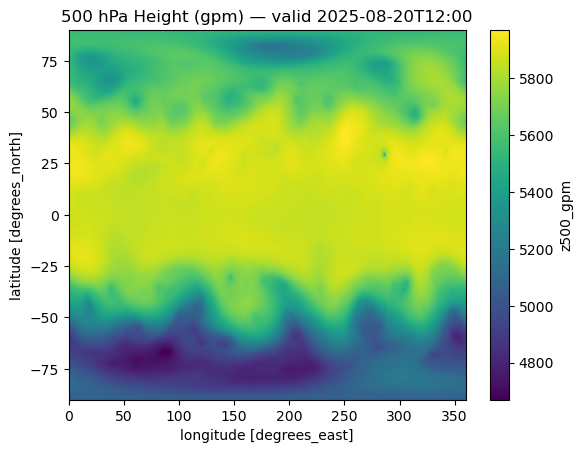

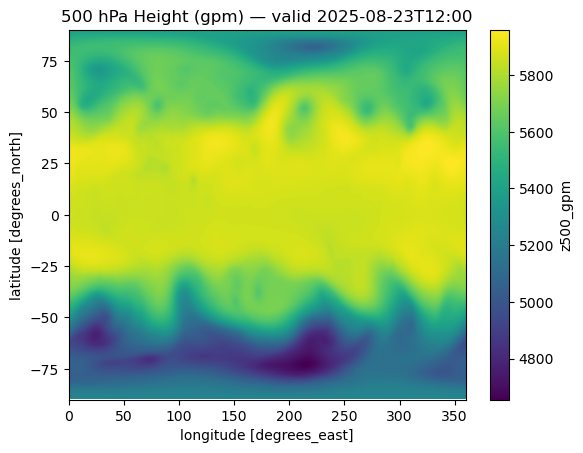

In [9]:
grib = "demo_output/aurora_forecast.grib"

ds_pl = xr.open_dataset(
    grib, engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "isobaricInhPa"}, "indexpath": ""}
)

print("Forecast time steps:", ds_pl.step.values[:6], "... last:", ds_pl.step.values[-1])

g0 = 9.80665
z500 = (ds_pl["z"].sel(isobaricInhPa=500) / g0).rename("z500_gpm")

for i in [0, -1]:
    valid = (ds_pl.time + ds_pl.step).isel(step=i).values
    z500.isel(step=i).plot()
    plt.title(f"500 hPa Height (gpm) — valid {np.datetime_as_string(valid, unit='m')}")
    plt.show()

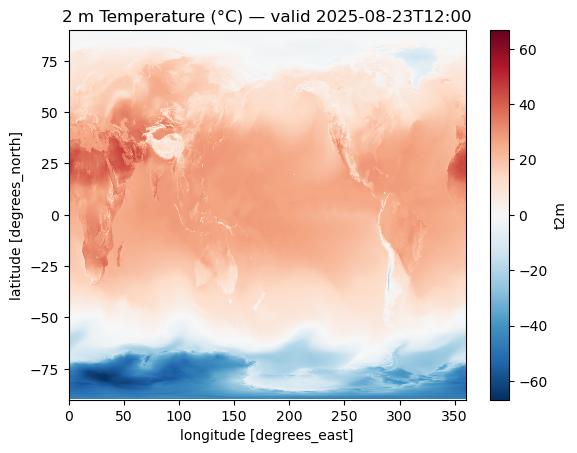

In [10]:
ds_h2 = xr.open_dataset(
    grib, engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "heightAboveGround", "level": 2}, "indexpath": ""}
)

tvar = next(v for v in ("t2m", "2t", "t") if v in ds_h2.data_vars)

i = -1

if "time" in ds_h2 and "step" in ds_h2:
    valid = (ds_h2["time"] + ds_h2["step"]).isel(step=i).values
elif "valid_time" in ds_h2:
    valid = ds_h2["valid_time"].isel(step=i).values
else:
    valid = np.datetime64('NaT')

t2m_c = (ds_h2[tvar].isel(step=i) - 273.15)
t2m_c.plot()
plt.title(f"2 m Temperature (°C) — valid {np.datetime_as_string(valid, unit='m')}")
plt.show()

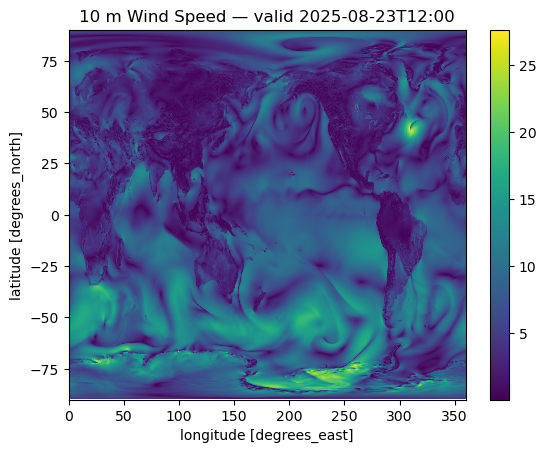

In [11]:
ds_h10 = xr.open_dataset(
    grib, engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "heightAboveGround", "level": 10}, "indexpath": ""}
)
i = -1
valid = (ds_h10.time + ds_h10.step).isel(step=i).values
ws10 = (ds_h10["u10"]**2 + ds_h10["v10"]**2)**0.5
ws10.isel(step=i).plot()
plt.title(f"10 m Wind Speed — valid {np.datetime_as_string(valid, unit='m')}")
plt.show()

## 8. NetCDF Conversion

Convert the Aurora GRIB output to NetCDF format for enhanced analysis capabilities and broader compatibility with scientific computing tools.

In [ ]:
if aurora_output.exists():
    print("Converting Aurora output to NetCDF...")
    
    def convert_to_netcdf(grib_file, netcdf_file):
        """
        Convert Aurora GRIB output to NetCDF format with enhanced metadata.
        """
        logger.info("Converting Aurora output to NetCDF format")
        
        ds = xr.open_dataset(
            grib_file,
            engine="cfgrib",
            backend_kwargs={
                "filter_by_keys": {},
                "read_keys": ["paramId", "cfName", "cfVarName", "units"],
                "errors": "ignore"
            }
        )
        
        ds.attrs.update({
            "title": "Aurora AI Weather Forecast",
            "source": "ECMWF IFS Open Data initial conditions",
            "model": "Microsoft Aurora",
            "model_version": "0.25° resolution",
            "initialization_time": latest_date.isoformat(),
            "forecast_lead_time_hours": LEAD_TIME,
            "created": datetime.utcnow().isoformat(),
            "conventions": "CF-1.8"
        })
        
        if "latitude" in ds.coords:
            ds.latitude.attrs.update({
                "long_name": "Latitude",
                "units": "degrees_north",
                "standard_name": "latitude"
            })
        
        if "longitude" in ds.coords:
            ds.longitude.attrs.update({
                "long_name": "Longitude",
                "units": "degrees_east",
                "standard_name": "longitude"
            })
        
        if "time" in ds.coords:
            ds.time.attrs.update({
                "long_name": "Forecast time",
                "standard_name": "time"
            })
        
        encoding = {}
        for var in ds.data_vars:
            encoding[var] = {
                "zlib": True,
                "complevel": 6,
                "shuffle": True
            }
        
        ds.to_netcdf(
            netcdf_file,
            format="NETCDF4",
            engine="netcdf4",
            encoding=encoding
        )
        
        var_info = {
            "variables": list(ds.data_vars.keys()),
            "dimensions": dict(ds.dims),
            "coordinates": list(ds.coords.keys())
        }
        
        ds.close()
        
        file_size = netcdf_file.stat().st_size / (1024 * 1024)
        logger.info(f"NetCDF conversion completed: {file_size:.1f} MB")
        
        return var_info
    
    start_time = time.time()
    
    try:
        var_info = convert_to_netcdf(aurora_output, netcdf_output)
        conversion_time = time.time() - start_time
        file_size = netcdf_output.stat().st_size / (1024 * 1024)
        
        print(f"NetCDF conversion completed in {conversion_time:.1f}s")
        print(f"NetCDF file size: {file_size:.1f} MB")
        print(f"Saved to: {netcdf_output}")
        
        print(f"\nDataset information:")
        print(f"   Variables: {len(var_info['variables'])}")
        print(f"   Dimensions: {var_info['dimensions']}")
        print(f"   Coordinates: {var_info['coordinates']}")
        
        if len(var_info['variables']) <= 10:
            print(f"   Variable list: {', '.join(var_info['variables'])}")
        else:
            print(f"   First 10 variables: {', '.join(var_info['variables'][:10])}...")
            
    except Exception as e:
        logger.error(f"NetCDF conversion failed: {e}")
        print(f"NetCDF conversion failed: {e}")
        print(f"The GRIB file is still available at: {aurora_output}")
        
else:
    print("Skipping NetCDF conversion - Aurora output file not found")

2025-08-20 16:29:18,107 - INFO - Converting Aurora output to NetCDF format


Converting Aurora output to NetCDF...


## Summary

This notebook demonstrates the complete workflow for near real-time global weather forecasting using Microsoft's Aurora AI model with ECMWF Open Data. The implementation showcases:

**Key Capabilities:**
- **Automated Data Access**: Real-time detection and download of latest IFS cycles
- **AI-Powered Forecasting**: State-of-the-art transformer-based weather prediction
- **High-Resolution Output**: Global forecasts at 0.25° spatial resolution
- **Operational Integration**: Production-ready workflow using ECMWF's recommended approach

**Technical Implementation:**
- **Data Source**: ECMWF IFS operational forecasts (updated 4x daily)
- **AI Model**: Microsoft Aurora foundation model for atmospheric forecasting  
- **Framework**: ai-models CLI with GPU acceleration support
- **Output**: GRIB and NetCDF formats for analysis and visualization

**Scientific Applications:**
- **Research**: Advanced atmospheric modeling and prediction studies
- **Operations**: Near real-time forecast production for decision support
- **Education**: Hands-on experience with state-of-the-art AI weather models
- **Development**: Foundation for ensemble forecasting and specialized applications

This workflow enables researchers, meteorologists, and students to access cutting-edge AI weather prediction technology, democratizing advanced atmospheric modeling capabilities through the combination of open data and open-source tools.

In [ ]:
# Load the Aurora forecast for analysis (only if NetCDF file exists)
if netcdf_output.exists():
    print("Loading Aurora forecast for analysis...")
    
    try:
        # Load NetCDF file
        ds = xr.open_dataset(netcdf_output)
        
        print(f"Aurora forecast loaded successfully")
        print(f"\nDataset overview:")
        print(f"   Dimensions: {dict(ds.dims)}")
        print(f"   Time range: {ds.time.min().values} to {ds.time.max().values}")
        print(f"   Spatial domain: {ds.latitude.min().values:.1f}°N to {ds.latitude.max().values:.1f}°N")
        print(f"                   {ds.longitude.min().values:.1f}°E to {ds.longitude.max().values:.1f}°E")
        
        # Show available variables with descriptions
        print(f"\nAvailable forecast variables:")
        for var in sorted(ds.data_vars.keys()):
            var_obj = ds[var]
            long_name = var_obj.attrs.get('long_name', 'No description')
            units = var_obj.attrs.get('units', 'No units')
            shape = var_obj.shape
            print(f"   {var:12s} - {long_name} ({units}) {shape}")

    except Exception as e:
        logger.error(f"Failed to load Aurora forecast: {e}")
        print(f"Could not load Aurora forecast: {e}")
        ds = None
        
else:
    print("NetCDF file not found - skipping forecast analysis")
    print("This is expected if Aurora execution or NetCDF conversion failed")
    ds = None

In [ ]:
# Create global weather forecast maps from the Aurora NetCDF (robust to scalar `time` and `step` axis)
# + adds a Near-surface / 10 m wind speed panel (uses u10/v10 if present, else lowest pressure level u/v proxy)
if ds is not None:
    print("Creating weather forecast maps...")

    # ------------------- Robust forecast-time handling (Aurora style) -------------------
    if "step" not in ds.dims:
        raise ValueError(f"No 'step' dimension found. ds.dims={dict(ds.dims)}")

    step_vals = ds["step"].values
    n_steps = ds.sizes["step"]
    if n_steps == 0:
        raise ValueError("Empty 'step' axis.")

    def _to_hours(arr):
        if np.issubdtype(arr.dtype, np.timedelta64):
            return (arr / np.timedelta64(1, "h")).astype(float)
        else:
            return np.asarray(arr, dtype=float)

    step_hours = _to_hours(step_vals)

    # Choose ~+24h (nearest available)
    target_hr = 24.0
    forecast_idx = int(np.argmin(np.abs(step_hours - target_hr)))
    forecast_idx = min(forecast_idx, n_steps - 1)
    lead_hr = int(round(step_hours[forecast_idx]))

    init_dt = pd.to_datetime(ds["time"].values) if "time" in ds.coords else None
    valid_dt = (init_dt + pd.to_timedelta(lead_hr, unit="h")) if init_dt is not None else None

    if valid_dt is not None:
        print(f"Plotting forecast for: {valid_dt} (lead {lead_hr}h, step idx {forecast_idx})")
    else:
        print(f"Plotting forecast for lead {lead_hr}h (step idx {forecast_idx})")

    def select_at_forecast(var_da):
        return var_da.isel(step=forecast_idx) if ("step" in var_da.dims) else var_da

    # ------------------- Fix longitude wrap -------------------
    if "longitude" in ds.coords:
        lon = ds["longitude"].values
        if np.nanmax(lon) > 180:
            lon_wrapped = ((lon + 180) % 360) - 180
            ds = ds.assign_coords(longitude=lon_wrapped).sortby("longitude")

    # ------------------- Variables to plot -------------------
    var_mapping = {
        "t2m": {"title": "2m Temperature (°C)", "cmap": "RdYlBu_r", "unit_convert": lambda x: x - 273.15},
        "msl": {"title": "Mean Sea Level Pressure (hPa)", "cmap": "viridis", "unit_convert": lambda x: x / 100},
        "tp":  {"title": "Total Precipitation (mm)", "cmap": "Blues", "unit_convert": lambda x: x * 1000},
        "u10": {"title": "10m U Wind (m/s)", "cmap": "RdBu_r", "unit_convert": None},
        "v10": {"title": "10m V Wind (m/s)", "cmap": "RdBu_r", "unit_convert": None},
        "tcwv":{"title": "Total Column Water Vapor (kg/m²)", "cmap": "Blues", "unit_convert": None},
    }
    available_vars = [(vn, info) for vn, info in var_mapping.items() if vn in ds.data_vars]

    # ---- Add a wind-speed panel (10m if available; otherwise proxy from lowest pressure level) ----
    have_true_10m = ("u10" in ds.data_vars) and ("v10" in ds.data_vars)
    have_pl_wind = ("u" in ds.data_vars) and ("v" in ds.data_vars) and ("isobaricInhPa" in ds.dims)
    add_wind_speed = have_true_10m or have_pl_wind

    # We'll handle this variable specially in the plotting loop using the key "__wind_speed__"
    if add_wind_speed:
        # Insert as the first panel after temperature if present, else just append
        insertion_idx = 1 if any(vn == "t2m" for vn, _ in available_vars) else len(available_vars)
        wind_spec = ("__wind_speed__", {"title": "Near-surface Wind Speed (m/s)", "cmap": "viridis", "unit_convert": None})
        available_vars[insertion_idx:insertion_idx] = [wind_spec]

    if not available_vars:
        print("No recognized surface variables found for plotting.")
        print(f"Available variables: {list(ds.data_vars.keys())}")
    else:
        # ------------------- Layout: make panels WIDE -------------------
        n_plots = min(len(available_vars), 6)

        # For 1–3 variables, use 2 columns so each panel is wide; otherwise 3 columns
        if n_plots <= 3:
            n_cols = min(2, n_plots)
        else:
            n_cols = 3
        n_rows = (n_plots + n_cols - 1) // n_cols

        # Wide figure: 11 inches per column, ~10 inches tall
        fig_width = max(11 * n_cols, 14)
        fig_height = 10
        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=(fig_width, fig_height),
            squeeze=False,
            gridspec_kw={"wspace": 0.18, "hspace": 0.22}
        )

        # If we need a proxy level for wind from pressure levels, choose the highest pressure (closest to surface)
        proxy_level = None
        if (not have_true_10m) and have_pl_wind:
            levels = ds["isobaricInhPa"].values
            try:
                proxy_level = float(np.nanmax(levels))
            except Exception:
                proxy_level = levels[int(np.argmax(levels))]

        # Plot
        for i, (var_name, var_info) in enumerate(available_vars[:n_plots]):
            r, c = divmod(i, n_cols)
            ax = axes[r][c]

            # ---- Special handling for wind-speed panel ----
            if var_name == "__wind_speed__":
                if have_true_10m:
                    u_da = select_at_forecast(ds["u10"])
                    v_da = select_at_forecast(ds["v10"])
                    data = np.sqrt(u_da**2 + v_da**2)
                    panel_title = "10m Wind Speed (m/s)"
                else:
                    # proxy from lowest pressure level (e.g., ~1000 hPa)
                    u_da = select_at_forecast(ds["u"]).sel(isobaricInhPa=proxy_level)
                    v_da = select_at_forecast(ds["v"]).sel(isobaricInhPa=proxy_level)
                    data = np.sqrt(u_da**2 + v_da**2)
                    panel_title = f"Near-surface Wind Speed (m/s) (~{int(proxy_level)} hPa)"

                # optional light decimation for speed/appearance on 3600×1801 grids
                if {"longitude", "latitude"}.issubset(data.coords):
                    data = data.isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))

                ax.set_aspect("auto")
                data.plot(
                    ax=ax,
                    x="longitude", y="latitude",
                    cmap="viridis",
                    add_colorbar=True,
                    rasterized=True,
                    robust=True,
                    cbar_kwargs={"shrink": 0.9, "pad": 0.015},
                )
                ax.set_xlim([-180, 180])
                ax.set_ylim([-90, 90])
                ax.set_title(panel_title, fontsize=12, fontweight="bold")
                continue  # done with wind-speed panel

            # ---- Default handling for normal variables ----
            data = select_at_forecast(ds[var_name])
            if var_info["unit_convert"] is not None:
                data = var_info["unit_convert"](data)

            if {"longitude", "latitude"}.issubset(data.coords):
                data = data.isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))

            ax.set_aspect("auto")
            data.plot(
                ax=ax,
                x="longitude", y="latitude",
                cmap=var_info["cmap"],
                add_colorbar=True,
                rasterized=True,
                robust=True,
                cbar_kwargs={"shrink": 0.9, "pad": 0.015},
            )

            # Keep a consistent world frame
            ax.set_xlim([-180, 180])
            ax.set_ylim([-90, 90])

            ax.set_title(var_info["title"], fontsize=12, fontweight="bold")

        # Hide any unused axes
        for j in range(n_plots, n_rows * n_cols):
            r, c = divmod(j, n_cols)
            axes[r][c].set_visible(False)

        # ------------------- Title -------------------
        if init_dt is not None and valid_dt is not None:
            init_str = init_dt.strftime("%Y-%m-%d %H")
            valid_str = valid_dt.strftime("%Y-%m-%d %H")
            lead_str = f"+{lead_hr}h"
        else:
            init_str, valid_str, lead_str = "n/a", "n/a", f"+{lead_hr}h"

        fig.suptitle(
            f"Aurora Weather Forecast\n"
            f"Init: {init_str}Z | Valid: {valid_str}Z | Lead time: {lead_str}",
            fontsize=16,
            fontweight="bold",
            y=0.99,
        )

        # Use tight layout but leave room for suptitle
        plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.95])

        # ------------------- Save & show -------------------
        plot_file = OUTPUT_DIR / "aurora_forecast_maps.png"
        plt.savefig(plot_file, dpi=150, bbox_inches="tight")
        print(f"Weather maps saved to: {plot_file}")

        plt.show()

else:
    print("Cannot create plots - dataset not loaded")

In [ ]:
# Aurora forecast time-series at selected cities (robust to scalar init `time`, `step` axis, and 0–360 lon)
if ds is not None:
    print("Creating time series analysis...")

    # ------------------- Helper: step -> hours -------------------
    def _step_to_hours(arr):
        arr = np.asarray(arr)
        if np.issubdtype(arr.dtype, np.timedelta64):
            return (arr / np.timedelta64(1, "h")).astype(float)
        return arr.astype(float)

    # ------------------- Build forecast times -------------------
    if "step" in ds.dims:
        step_hours = _step_to_hours(ds["step"].values)
        init_dt = None
        if "time" in ds.coords:
            t = ds["time"]
            init_dt = pd.to_datetime(t.values if t.ndim == 0 else t.values[0])
        times = (
            pd.to_datetime(init_dt) + pd.to_timedelta(step_hours, unit="h")
            if init_dt is not None
            else pd.to_timedelta(step_hours, unit="h")
        )
        time_is_datetime = init_dt is not None
        time_dim = "step"
    else:
        time_dim = "time"
        times = pd.to_datetime(ds[time_dim].values)
        time_is_datetime = True
        init_dt = times[0] if len(times) else None

    # ------------------- Normalize dataset longitude -------------------
    if "longitude" in ds.coords:
        lon_vals = ds["longitude"].values
        if np.nanmax(lon_vals) > 180:
            lon_wrapped = ((lon_vals + 180) % 360) - 180
            ds = ds.assign_coords(longitude=lon_wrapped).sortby("longitude")

    def _wrap_lon(lon):
        return ((lon + 180) % 360) - 180

    # ------------------- Locations -------------------
    locations = {
        "Phoenix, AZ": {"lat": 33.4, "lon": -112.0},
        "London, UK": {"lat": 51.5, "lon": 0.0},
        "Tokyo, Japan": {"lat": 35.7, "lon": 139.7},
        "Sydney, Australia": {"lat": -33.9, "lon": 151.2},
    }
    for k in locations:
        locations[k]["lon"] = _wrap_lon(locations[k]["lon"])

    # ------------------- Variables to plot -------------------
    ts_vars = []
    if "t2m" in ds.data_vars:
        ts_vars.append(("t2m", "2m Temperature (°C)", lambda x: x - 273.15))
    if "msl" in ds.data_vars:
        ts_vars.append(("msl", "Mean Sea Level Pressure (hPa)", lambda x: x / 100))
    if "tp" in ds.data_vars:
        ts_vars.append(("tp", "Total Precipitation (mm)", lambda x: x * 1000))

    # 10m wind: prefer true u10/v10; otherwise use lowest pressure-level u/v as a proxy (~1000 hPa)
    have_true_10m = ("u10" in ds.data_vars) and ("v10" in ds.data_vars)
    have_pl_wind = ("u" in ds.data_vars) and ("v" in ds.data_vars) and ("isobaricInhPa" in ds.dims)
    if have_true_10m or have_pl_wind:
        ts_vars.append(("wind10_like", "Near-surface Wind Speed (m/s)", None))  # handled specially

    if ts_vars:
        nrows = len(ts_vars)
        fig, axes = plt.subplots(nrows, 1, figsize=(16, 4.5 * nrows), constrained_layout=False)
        if nrows == 1:
            axes = [axes]

        # pick a near-surface pressure level if needed
        proxy_level = None
        if not have_true_10m and have_pl_wind:
            # choose the highest pressure (closest to surface)
            levels = ds["isobaricInhPa"].values
            try:
                proxy_level = float(np.nanmax(levels))
            except Exception:
                proxy_level = levels[int(np.argmax(levels))]

        for i, (var_name, var_title, convert_func) in enumerate(ts_vars):
            ax = axes[i]

            for loc_name, coords in locations.items():
                try:
                    if var_name == "wind10_like":
                        if have_true_10m:
                            uu = ds["u10"].sel(latitude=coords["lat"], longitude=coords["lon"], method="nearest")
                            vv = ds["v10"].sel(latitude=coords["lat"], longitude=coords["lon"], method="nearest")
                            point_da = np.sqrt(uu**2 + vv**2)
                            title_suffix = ""
                        else:
                            # proxy from lowest pressure level (e.g., ~1000 hPa)
                            uu = ds["u"].sel(
                                latitude=coords["lat"], longitude=coords["lon"], method="nearest"
                            ).sel(isobaricInhPa=proxy_level)
                            vv = ds["v"].sel(
                                latitude=coords["lat"], longitude=coords["lon"], method="nearest"
                            ).sel(isobaricInhPa=proxy_level)
                            point_da = np.sqrt(uu**2 + vv**2)
                            title_suffix = f"  (~{int(proxy_level)} hPa proxy)"
                    else:
                        point_da = ds[var_name].sel(
                            latitude=coords["lat"], longitude=coords["lon"], method="nearest"
                        )
                        if convert_func is not None:
                            point_da = convert_func(point_da)

                    y = point_da.values

                    if time_is_datetime:
                        x = times
                        ax.plot(x, y, marker="o", linewidth=2, label=loc_name)
                        ax.set_xlabel("Forecast Time (UTC)")
                        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H"))
                        ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
                    else:
                        x = np.asarray(step_hours)
                        ax.plot(x, y, marker="o", linewidth=2, label=loc_name)
                        ax.set_xlabel("Lead Time (hours)")

                except Exception as e:
                    print(f"Could not extract data for {loc_name}: {e}")

            # Title (append proxy note for wind if used)
            if var_name == "wind10_like":
                ax.set_title("10m Wind Speed (m/s)" + (title_suffix if 'title_suffix' in locals() else ""), fontsize=12, fontweight="bold")
            else:
                ax.set_title(var_title, fontsize=12, fontweight="bold")

            ax.grid(True, alpha=0.3)
            ax.legend(loc="upper right", frameon=True)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        # ------------------- Figure title -------------------
        title_init = pd.to_datetime(init_dt).strftime("%Y-%m-%d %H") if init_dt is not None else "n/a"
        fig.suptitle(
            f"Aurora Forecast Time Series\nInitialization: {title_init}Z",
            fontsize=16, fontweight="bold", y=0.99
        )

        plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.95])

        ts_plot_file = OUTPUT_DIR / "aurora_time_series.png"
        plt.savefig(ts_plot_file, dpi=150, bbox_inches="tight")
        print(f"Time series plot saved to: {ts_plot_file}")

        plt.show()
    else:
        print("No suitable variables found for time series analysis")
else:
    print("Cannot create time series - dataset not loaded")

In [ ]:
print("Generating Aurora Forecast Summary Report")
print("=" * 60)

# Calculate total elapsed time from beginning of notebook
total_time = time.time() - start_time if 'start_time' in locals() else 0

# Collect file information
file_info = {}
for name, path in [
    ('Surface GRIB', sfc_file),
    ('Pressure Level GRIB', pl_file),
    ('Aurora Input', init_file),
    ('Aurora Output', aurora_output),
    ('NetCDF Output', netcdf_output)
]:
    if path.exists():
        size_mb = path.stat().st_size / (1024 * 1024)
        file_info[name] = f"{size_mb:.1f} MB"
    else:
        file_info[name] = "Not found"

# System information
system_info = {
    'Platform': os.uname().sysname,
    'Node': os.uname().nodename,
    'CPU Count': psutil.cpu_count(),
    'Memory Total': f"{psutil.virtual_memory().total / (1024**3):.1f} GB",
    'CUDA Available': torch.cuda.is_available(),
}

if torch.cuda.is_available():
    system_info['GPU'] = torch.cuda.get_device_name(0)
    system_info['GPU Memory'] = f"{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB"

# Forecast quality metrics (if dataset loaded)
quality_metrics = {}
if 'ds' in locals() and ds is not None:
    try:
        # Basic data quality checks
        n_variables = len(ds.data_vars)
        n_timesteps = len(ds.time)
        spatial_resolution = abs(float(ds.latitude[1] - ds.latitude[0]))
        
        quality_metrics = {
            'Variables': n_variables,
            'Time Steps': n_timesteps,
            'Spatial Resolution': f"{spatial_resolution:.2f}°",
            'Domain': f"{float(ds.latitude.min()):.1f}° to {float(ds.latitude.max()):.1f}°N, "
                     f"{float(ds.longitude.min()):.1f}° to {float(ds.longitude.max()):.1f}°E"
        }
        
        # Check for NaN values in key variables
        for var in ['t2m', 'msl', 'u10', 'v10']:
            if var in ds.data_vars:
                nan_count = ds[var].isnull().sum().values
                quality_metrics[f'{var.upper()} NaN count'] = int(nan_count)
        
    except Exception as e:
        quality_metrics['Error'] = str(e)

# Print formatted report
print(f"\nAURORA FORECAST DEMONSTRATION COMPLETED")
print(f"\nForecast Information:")
if 'latest_date' in locals() and 'latest_cycle' in locals():
    print(f"   Initialization: {latest_date.strftime('%Y-%m-%d %H:%M')} UTC")
    print(f"   Cycle: {latest_cycle:02d}Z")
else:
    print(f"   Initialization: Not completed")
print(f"   Lead Time: {LEAD_TIME} hours")
print(f"   Model: Microsoft Aurora (0.25° resolution)")

print(f"\nFile Sizes:")
for name, size in file_info.items():
    print(f"   {name:20s}: {size}")

print(f"\nSystem Information:")
for key, value in system_info.items():
    print(f"   {key:15s}: {value}")

if quality_metrics:
    print(f"\nForecast Quality Metrics:")
    for key, value in quality_metrics.items():
        print(f"   {key:20s}: {value}")

print(f"\nPerformance Summary:")
if 'detection_time' in locals():
    print(f"   Cycle Detection: {detection_time:.1f}s")
if 'download_time' in locals():
    print(f"   Data Download: {download_time:.1f}s")
if 'forecast_time' in locals():
    print(f"   Aurora Forecast: {forecast_time:.1f}s ({forecast_time/60:.1f} min)")
if 'conversion_time' in locals():
    print(f"   NetCDF Conversion: {conversion_time:.1f}s")
print(f"   Total Runtime: {total_time:.1f}s ({total_time/60:.1f} min)")

print(f"\nOutput Files:")
print(f"   Working Directory: {OUTPUT_DIR}")
print(f"   Aurora Forecast: {aurora_output.name}")
print(f"   NetCDF Format: {netcdf_output.name}")
print(f"   Weather Maps: aurora_forecast_maps.png (if created)")
print(f"   Time Series: aurora_time_series.png (if created)")
print(f"   Log File: logs/aurora_demo.log")

print(f"\nNext Steps:")
print(f"   1. Analyze forecast data with: xarray.open_dataset('{netcdf_output}')")
print(f"   2. Compare with observations or other models")
print(f"   3. Create custom visualizations for your research")
print(f"   4. Run automation script for regular forecasts")
print(f"   5. Submit Slurm jobs for operational use")

print(f"\nAurora demonstration completed!")
print(f"=" * 60)

# Save summary to file
summary_file = OUTPUT_DIR / "forecast_summary.txt"
with open(summary_file, 'w') as f:
    f.write(f"Aurora Forecast Summary\n")
    f.write(f"Generated: {datetime.utcnow().isoformat()}\n\n")
    if 'latest_date' in locals():
        f.write(f"Forecast: {latest_date.strftime('%Y-%m-%d %H:%M')} UTC + {LEAD_TIME}h\n")
    else:
        f.write(f"Forecast: Incomplete\n")
    f.write(f"Files: {', '.join([f'{k}: {v}' for k, v in file_info.items()])}\n")
    f.write(f"Runtime: {total_time:.1f}s\n")

print(f"\nSummary saved to: {summary_file}")

# Clean up
if 'ds' in locals() and ds is not None:
    ds.close()